In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:

dic_files = {
    'file01': {
        'filePath': "./filled/",
        'fileName': "IBOV_filled.csv",
        'saveFilePath': "./filled/",
        'saveFileName': "IBOV_filled.csv",
        'delimiter': ",",
        'decimal': ".",
        'parse_dates': ["Data"],
        'date_format': "%Y-%m-%d",
        'index': "Data",
        'cols': {
            'variavel' : 'Close_filled',
            'k_regimes': 3, # number of regimes
            # Array of exogenous regressors, shaped nobs x k. If None, no exogenous regressors are included.
            'order': 4, # Order of the model describes the dependence of the likelihood on previous regimes.
            'trend': 'ct', # trend{‘n’, ‘c’, ‘t’, ‘ct’} none ='n'; intercept='c' (default);trend = 't'; both = 'ct'.
            'switching_trend': True, # 'switching_trend': True / False / iterable; whether or not all trend coefficients are switching across regimes. If iterable: each element is a boolean describing whether the corresponding coefficient is switching.
            'switching_ar': True, # whether or not the AR coefficients are switching across regimes.
            'switching_variance': False # whether or not the error variance is switching across regimes.
            }
    }
} # end of dic_files

In [3]:
config = dic_files['file01']

In [4]:
# Create full file path by joining directory and filename
file_path = os.path.join(config['filePath'], config['fileName'])

print(f"Processing file: {file_path}")

# reading data
try:
    df = pd.read_csv(file_path,
                        delimiter=config['delimiter'],
                        decimal=config['decimal'],
                        header=0,
                        parse_dates=config['parse_dates'],
                        date_format=config['date_format'])
except FileNotFoundError:
    print(f"Error: File not found: {file_path}")
except pd.errors.EmptyDataError:
    print(f"Error: File is empty: {file_path}")
except Exception as e:
    print(f"Error reading file {file_path}: {e}")




Processing file: ./filled/IBOV_filled.csv


In [5]:

df.set_index(config['index'], inplace=True)
df = df.asfreq('B')

print(f"Data read successfully. DataFrame shape: {df.shape}")
print(df.describe(include='all'))

Data read successfully. DataFrame shape: (5220, 7)
       Ativo          Close  Close_level_Smoothed  Close_level_filtered  \
count   5220    4957.000000           5220.000000           5220.000000   
unique     1            NaN                   NaN                   NaN   
top     IBOV            NaN                   NaN                   NaN   
freq    5220            NaN                   NaN                   NaN   
mean     NaN   77050.956605          76958.976600          76955.079437   
std      NaN   30279.675910          30206.817584          30210.179598   
min      NaN   29435.000000          28616.075253          28433.633678   
25%      NaN   53558.000000          53524.718568          53554.658963   
50%      NaN   65317.000000          65362.916467          65337.817705   
75%      NaN  104891.320000         104785.421804         104775.163883   
max      NaN  157748.600000         157647.994439         157698.964538   

        Close_fittedvalues   Close_resid   Close

In [6]:
df['Close_filled'].values.reshape(-1, 1)

array([[ 31102.        ],
       [ 31110.        ],
       [ 31489.        ],
       ...,
       [156522.13      ],
       [155380.66      ],
       [155467.09994696]], shape=(5220, 1))

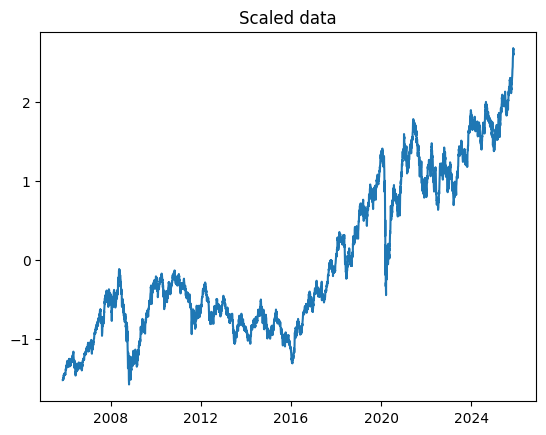

In [7]:
from sklearn.preprocessing import StandardScaler


df['ma'] = df[config['cols']['variavel']].rolling(window=50, min_periods=1).mean()

# # Plot the data
# df[['ma_5', config['cols']['variavel']]].plot(title="ma_5 and Close_filled", figsize=(12, 3))
# df[['ma', "Close_filled"]].plot(title="ma_5 and Close_filled", figsize=(12, 3))

# # df[config['cols']['variavel']].diff().plot(title="Close_filled", figsize=(12, 3))
# # df.plot(title="Growth rate of Real GNP", figsize=(12, 3))


scaler = StandardScaler()
df['joe'] = scaler.fit_transform(df['Close_filled'].values.reshape(-1, 1))

plt.plot(df['joe'])
plt.title("Scaled data")
plt.show()

In [12]:
df['log_return'] = np.log(df['Close_filled'] / df['Close_filled'].shift(1))

df['Close_filled_scaled'] = scaler.transform(df['Close_filled'].values.reshape(-1, 1))


In [21]:
# Define the model
# Using Hamilton's specification: 2 regimes, AR(4) process, only the mean (intercept) switches
mod_MKS = sm.tsa.MarkovRegression(
    # df.loc['2018-01-12':]['Close_filled_scaled'],  # Time series data
    # IBOV_mensal_dia_28_sb.tail(200)/10000
    df.tail(200)['Close_filled']/100000,  # Time series data
    # df['log_return'].dropna(),  # Time series data
    k_regimes = 3,               # Number of regimes
    # exog=df.loc['2018-01-11':]['Close_filled'][1:]/100000,
    trend = 'ct',                 # Trend specification
    switching_trend = True,     # Whether trend coefficients switch across regimes
    # switching_exog  = True,
    switching_variance = True    # Variance is the same across regimes
)

# Fit the model using maximum likelihood estimation
# The .fit() method automatically finds good starting parameters via the EM algorithm
# MKS_result = mod_MKS.fit(disp=True, maxiter=1000, full_output=True, method='b', transformed=False,  em_iter=0)
# MKS_result = mod_MKS.fit(disp=True, maxiter=1000)
MKS_result = mod_MKS.fit(em_iter=200, search_reps=3000, search_iter=500, init_params='random', method='powell')




# try:
#     MKS_result = mod_MKS.fit(disp=True)
#     # MKS_result.summary()
# except np.linalg.LinAlgError as e:
#     print(f"Linear algebra error fitting Markov Switching Model to file {file_path}: {e}")
# except Exception as e:
#     print(f"Error fitting Markov Switching Model to file {file_path}: {e}")

c:\Users\bteba\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method powell is: xtol, ftol, maxfun, start_direc. The list of unsupported keyword arguments passed include: init_params. After release 0.14, this will raise.
  warnings.warn(


In [19]:
MKS_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:           Close_filled   No. Observations:                 2050
Model:               MarkovRegression   Log Likelihood                2934.107
Date:                Fri, 12 Dec 2025   AIC                          -5838.214
Time:                        11:02:17   BIC                          -5753.830
Sample:                    01-12-2018   HQIC                         -5807.268
                         - 11-20-2025                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7895   1.04e-16   7.56e+15      0.000       0.789       0.789
x1             0.0040        nan        nan        nan         nan         nan
sigma2      1.233e-32   6.65e-12   1.85e-21      1.000    -1.3e-11     1.3e-11
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8325   1.55e-19   5.37e+18      0.000       0.832       0.832
x1             0.0004   1.29e-18   3.48e+14      0.000       0.000       0.000
sigma2         0.0018   3.76e-32    4.9e+28      0.000       0.002       0.002
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7252   1.78e-19   4.08e+18      0.000       0.725       0.725
x1             0.0003   1.29e-18   2.48e+14      0.000       0.000       0.000
sigma2         0.0045   9.29e-33   4.86e+29      0.000       0.005       0.005
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9783   1.32e-19   7.42e+18      0.000       0.978       0.978
p[1->0]        0.0007   1.29e-18   5.39e+14      0.000       0.001       0.001
p[2->0]        0.0004   1.29e-18   3.29e+14      0.000       0.000       0.000
p[0->1]        0.0217   1.29e-18   1.68e+16      0.000       0.022       0.022
p[1->1]        0.9940    1.3e-19   7.66e+18      0.000       0.994       0.994
p[2->1]        0.0018   1.29e-18   1.37e+15      0.000       0.002       0.002
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 6.55e+56. Standard errors may be unstable.
"""

In [10]:
config['cols']['variavel']

'Close_filled'

[Text(0.5, 1.0, 'Filtered probability of recession')]

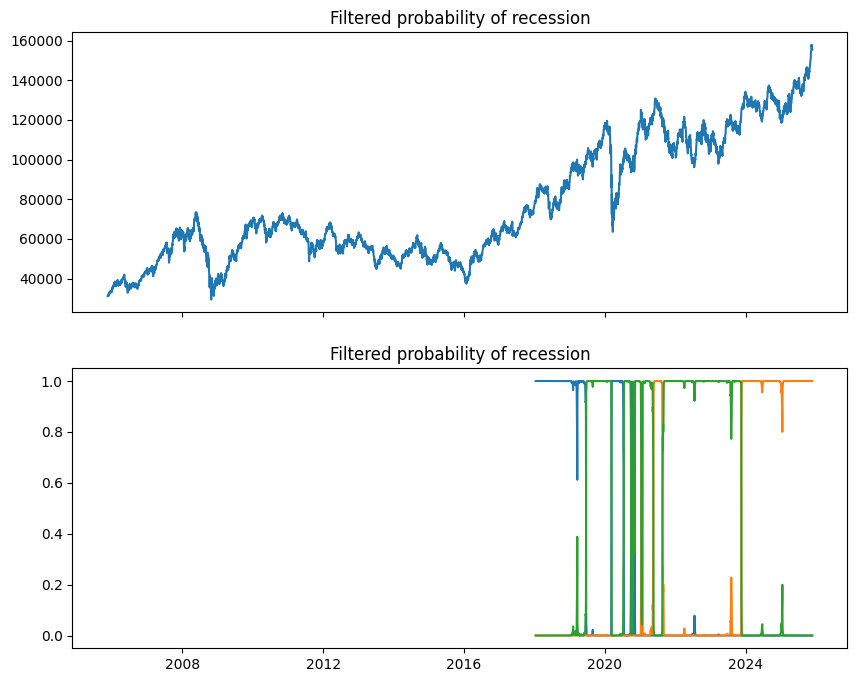

In [266]:
# Print the model summary

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax = axes[0]
ax.plot(df[config['cols']['variavel']])
# ax.plot(MKS_result.filtered_marginal_probabilities[0])

# ax.fill_between(df.index[:], 0, 150000, where=(MKS_result.filtered_marginal_probabilities[0] > 0.5), color="y", alpha=0.1)
# ax.fill_between(df.index[:], 0, 150000, where=(MKS_result.filtered_marginal_probabilities[1] > 0.5), color="r", alpha=0.1)
# ax.fill_between(df.index[:], 0, 150000, where=(MKS_result.filtered_marginal_probabilities[2] > 0.5), color="b", alpha=0.1)

# ax.fill_between(df.index[MKS_result.order:], 0, 150000, where=(MKS_result.filtered_marginal_probabilities[1] > 0.5), color="b", alpha=0.1)
# ax.fill_between(df.index[MKS_result.order:], 0, 150000, where=(MKS_result.filtered_marginal_probabilities[2] > 0.5), color="b", alpha=0.1)
# ax.set_xlim(MKS_result.index[4], MKS_result.index[-1])
ax.set(title="Filtered probability of recession")

ax = axes[1]
ax.plot(MKS_result.filtered_marginal_probabilities)
# ax.fill_between(df.index[MKS_result.order:], 0, 150000, where=(MKS_result.filtered_marginal_probabilities[1] > 0.5), color="y", alpha=0.1)
ax.set(title="Filtered probability of recession")

# ax.plot(MKS_result.smoothed_marginal_probabilities[0])
# # ax.fill_between(usrec.index, 0, 1, where=usrec["USREC"].values, color="k", alpha=0.1)
# # ax.set_xlim(MKS_result.index[4], MKS_result.index[-1])
# ax.set(title="Filtered probability of recession")

In [14]:
# Define the model
# Using Hamilton's specification: 2 regimes, AR(4) process, only the mean (intercept) switches
mod_MKS = sm.tsa.MarkovAutoregression(
    # df['ma_5'],  # Time series data
    df['Close_filled'],  # Time series data
    k_regimes = 3,               # Number of regimes
    order = 1,                   # AR order
    trend = 'ct',                # Trend specification
    # freq = 'D',                  # Daily frequency
    switching_trend = True,      # Whether trend coefficients switch across regimes
    switching_ar = True,        # AR coefficients are the same across regimes
    switching_variance = True   # Variance is the same across regimes
)

# Fit the model using maximum likelihood estimation
# The .fit() method automatically finds good starting parameters via the EM algorithm
try:
    MKS_result = mod_MKS.fit()
    MKS_result.summary()
except np.linalg.LinAlgError as e:
    print(f"Linear algebra error fitting Markov Switching Model to file {file_path}: {e}")
except Exception as e:
    print(f"Error fitting Markov Switching Model to file {file_path}: {e}")

Linear algebra error fitting Markov Switching Model to file ./filled/IBOV_filled.csv: SVD did not converge
